In [2]:
import h5py as hp
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import illustris_python as il
import matplotlib.gridspec as gspec
import matplotlib as mpl
import copy
from hc_lib.plots.fig_lib import FigureLibrary
tngpath = '/lustre/cosinga/L75n1820TNG/'
basepath = '/lustre/cosinga/hcolor/fig_md_analysis/'

In [3]:
fsr = hp.File(basepath+'HIXgalaxy/HIxGal_fieldnameR_spaceC_redshift.hdf5', 'r')
rfc = hp.File(basepath+'HIXgalaxy/HIxGal_redshiftR_fieldnameC_color.hdf5', 'r')
head = il.groupcat.loadHeader(tngpath+'output/', 99)


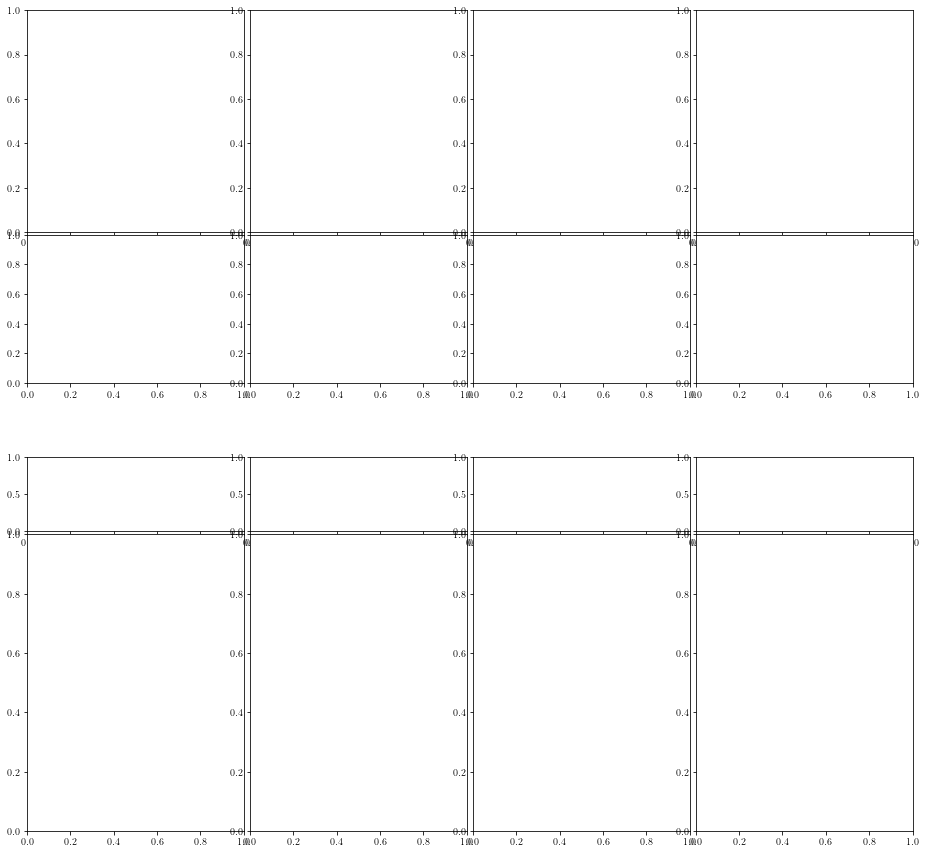

In [10]:
# first figure
nrows = 5
ndist = 2
ncols = 4
xborder = 1
yborder = 1
panel_bt = 0.1
panel_length = 3
dist_panel_length = 1

# border input can be either a list or single number
if isinstance(xborder, float) or isinstance(xborder, int):
    xborder = [xborder, xborder]
if isinstance(yborder, float) or isinstance(yborder, int):
    yborder = [yborder, yborder]
if isinstance(panel_bt, float) or isinstance(panel_bt, int):
    panel_bt = [panel_bt, panel_bt]
# creating Figure object

figwidth = panel_length * ncols + panel_bt[0] * (ncols - 1) + \
        xborder[0] + xborder[1]
figheight = panel_length * (nrows-ndist) + dist_panel_length * ndist + panel_bt[1] * (nrows - 1) + \
        yborder[0] + yborder[1]

fig = plt.figure(figsize=(figwidth, figheight))

# creating gridspec
gs = gspec.GridSpec(11, ncols)
plt.subplots_adjust(left= xborder[0]/figwidth, right=1-xborder[1]/figwidth,
        top=1-yborder[1]/figheight, bottom=yborder[0]/figheight,
        wspace=panel_bt[0]*ncols/figwidth, hspace=panel_bt[1]*nrows/figheight)

# making panels list
panels = []
dist_panels = []
for j in range(ncols):
    col_panels = []
    col_panels.append(fig.add_subplot(gs[:3, j]))
    #col_panels.append(fig.add_subplot(gs[3:7, j]))
    gs_sub1 = gspec.GridSpecFromSubplotSpec(4,1,subplot_spec = gs[3:7, j],wspace=0, hspace=0)
    col_panels.append(fig.add_subplot(gs_sub1[:2]))
    dist_panels.append(fig.add_subplot(gs_sub1[3]))
    col_panels.append(fig.add_subplot(gs[7:, j]))
    panels.append(col_panels)



